# Do Expensive Cars Really Speed More?
### DSA210 – Data Science Project

This notebook uses:

- Traffic violations data (Maryland)
- U.S. car sales / price data

to analyze whether higher-priced vehicle brands are more frequently involved in speeding violations than expected from their presence in the car market.


In [3]:
# importing files
from google.colab import files

print("Please upload: Traffic_Violations_Cleaned.csv and cars.csv")
uploaded = files.upload()


Please upload: Traffic_Violations_Cleaned.csv and cars.csv


Saving cars.csv to cars.csv
Saving Traffic_Violations_Cleaned.csv to Traffic_Violations_Cleaned.csv


In [4]:
# Basic data stack
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency

# Display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# Global plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["figure.autolayout"] = True



## 2. Load Data

Upload the two CSV files into this Colab environment:

- `Traffic_Violations_Cleaned.csv`
- `cars.csv`

or place them in your Google Drive and update the paths.


In [5]:
viol_path = "Traffic_Violations_Cleaned.csv"
cars_path = "cars.csv"

# Try loading Traffic Violations with robust encoding
try:
    viol_df = pd.read_csv(viol_path, low_memory=False)
except UnicodeDecodeError:
    viol_df = pd.read_csv(viol_path, encoding='latin1', low_memory=False)

# Try loading Cars with robust encoding
try:
    cars_df = pd.read_csv(cars_path) # Try standard first
except UnicodeDecodeError:
    try:
        cars_df = pd.read_csv(cars_path, encoding='utf-16') # Try utf-16
    except:
        cars_df = pd.read_csv(cars_path, encoding='latin1') # Fallback

viol_df.head(), cars_df.head()


(  Time Of Stop    Agency                                         Location  \
 0   05/01/2023  23:11:00                      3rd District, Silver Spring   
 1   08/31/2023  16:41:00  6th District, Gaithersburg / Montgomery Village   
 2   08/31/2023  16:41:00  6th District, Gaithersburg / Montgomery Village   
 3   08/31/2023  16:41:00  6th District, Gaithersburg / Montgomery Village   
 4   08/31/2023  16:41:00  6th District, Gaithersburg / Montgomery Village   
 
                                            Violation  \
 0    OPERATING UNREGISTERED MOTOR VEHICLE ON HIGHWAY   
 1  DRIVING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITH...   
 2  FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...   
 3  DRIVER OF MOTOR VEHICLE FOLLOWING VEHICLE CLOS...   
 4  FAILURE TO CONTROL VEH. SPEED ON HWY. TO AVOID...   
 
                            Latitude  Longitude  Latitude.1 Belts     Year  \
 0  BRIGGS CHANEY RD @ COLUMIBA PIKE       0.00        0.00    No 2,007.00   
 1       OAKMONT AVE @ GROVEMO

## 3. Basic Exploratory Data Analysis (EDA)

We start by:
- Checking shapes (number of rows/columns)
- Looking at columns and data types
- Checking missing values
- Exploring the distribution and range of car prices.
- Getting a feel for brands and models present in each dataset


In [6]:
print("Violations data shape:", viol_df.shape)
print("Cars data shape:", cars_df.shape)

print("\nViolations columns:\n", viol_df.columns.tolist())
print("\nCars columns:\n", cars_df.columns.tolist())

print("\nViolations info:")
display(viol_df.info())

print("\nCars info:")
display(cars_df.info())

print("\nSample violations rows:")
display(viol_df.head())

print("\nSample car price rows:")
display(cars_df.head())

print("\nMissing values in violations:")
display(viol_df.isna().sum())

print("\nMissing values in cars:")
display(cars_df.isna().sum())


Violations data shape: (1048575, 11)
Cars data shape: (144867, 7)

Violations columns:
 ['Time Of Stop', 'Agency', 'Location', 'Violation', 'Latitude', 'Longitude', 'Latitude.1', 'Belts', 'Year', 'Make', 'Model']

Cars columns:
 ['Brand', 'Model', 'Year', 'Status', 'Mileage', 'Dealer', 'Price']

Violations info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Time Of Stop  1048575 non-null  object 
 1   Agency        1048575 non-null  object 
 2   Location      1048575 non-null  object 
 3   Violation     1048566 non-null  object 
 4   Latitude      1048574 non-null  object 
 5   Longitude     1048575 non-null  float64
 6   Latitude.1    1048575 non-null  float64
 7   Belts         1048575 non-null  object 
 8   Year          1042872 non-null  float64
 9   Make          1048550 non-null  object 
 10  Model         1048490 non-nu

None


Cars info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    144867 non-null  object 
 1   Model    144867 non-null  object 
 2   Year     144867 non-null  int64  
 3   Status   144867 non-null  object 
 4   Mileage  55914 non-null   float64
 5   Dealer   144539 non-null  object 
 6   Price    140956 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 7.7+ MB


None


Sample violations rows:


,Time Of Stop,Agency,Location,Violation,Latitude,Longitude,Latitude.1,Belts,Year,Make,Model
0,05/01/2023,23:11:00,"3rd District, Silver Spring",OPERATING UNREGISTERED MOTOR VEHICLE ON HIGHWAY,BRIGGS CHANEY RD @ COLUMIBA PIKE,0.00,0.00,No,"2,007.00",CHEV,CRUZ
1,08/31/2023,16:41:00,"6th District, Gaithersburg / Montgomery Village",DRIVING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITH...,OAKMONT AVE @ GROVEMONT CIR,39.10,-77.15,No,"2,005.00",FORD,EXPLORER
2,08/31/2023,16:41:00,"6th District, Gaithersburg / Montgomery Village",FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...,OAKMONT AVE @ GROVEMONT CIR,39.10,-77.15,No,"2,005.00",FORD,EXPLORER
3,08/31/2023,16:41:00,"6th District, Gaithersburg / Montgomery Village",DRIVER OF MOTOR VEHICLE FOLLOWING VEHICLE CLOS...,OAKMONT AVE @ GROVEMONT CIR,39.10,-77.15,No,"2,005.00",FORD,EXPLORER
4,08/31/2023,16:41:00,"6th District, Gaithersburg / Montgomery Village",FAILURE TO CONTROL VEH. SPEED ON HWY. TO AVOID...,OAKMONT AVE @ GROVEMONT CIR,39.10,-77.15,No,"2,005.00",FORD,EXPLORER



Sample car price rows:


,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,NaN,"36,703.00"
1,Kia,Sportage,2023,New,NaN,Classic Kia,"28,990.00"
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,"41,425.00"
3,Ford,Bronco,2023,Used,"1,551.00",Mike Smith Chrysler Dodge Jeep RAM,"58,900.00"
4,Acura,TLX,2021,Used,"30,384.00",Mike Smith Nissan,"34,499.00"



Missing values in violations:


,0
Time Of Stop,0
Agency,0
Location,0
Violation,9
Latitude,1
Longitude,0
Latitude.1,0
Belts,0
Year,5703
Make,25



Missing values in cars:


,0
Brand,0
Model,0
Year,0
Status,0
Mileage,88953
Dealer,328
Price,3911


## 4. Cleaning & Data Integration

Steps:

1. Standardize brand / make text (uppercase, stripped).
2. Clean car prices (remove missing/zero prices).
3. Compute **brand-level average price**.
4. Define three price tiers:
   - Budget: < \$30,000  
   - Mid: \$30,000–\$50,000  
   - Luxury: > \$50,000
5. Merge tiers into the violations dataset via `Make` (traffic) ↔ `Brand` (cars).


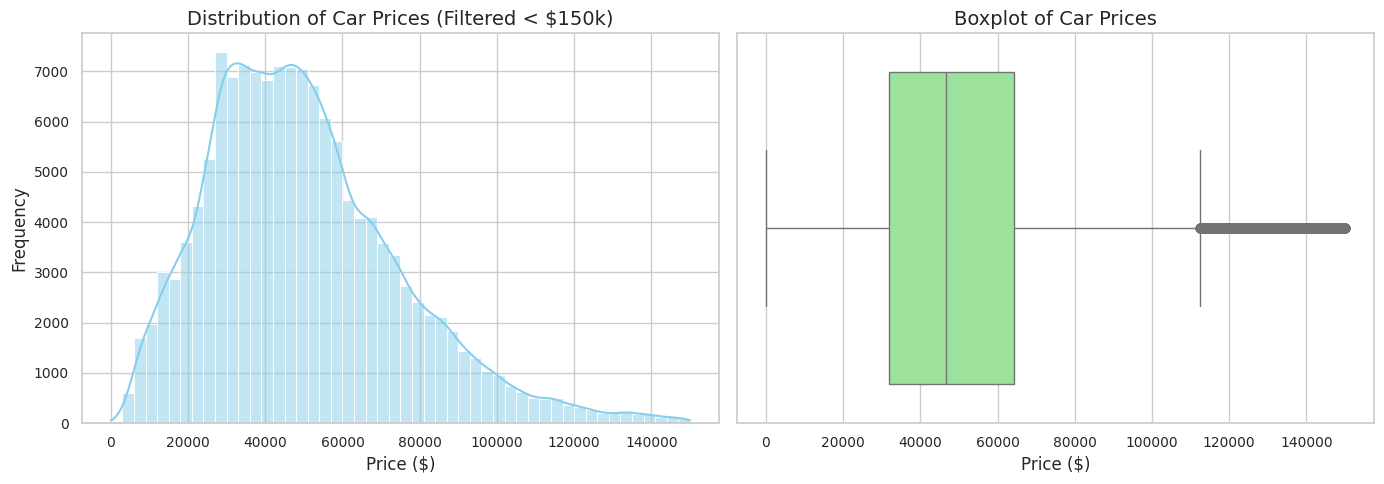

Price Summary Statistics:
count     140,956.00
mean       52,678.89
std        42,215.04
min             1.00
25%        32,110.00
50%        47,072.00
75%        65,311.25
max     8,078,160.00
Name: Price, dtype: float64


,Brand_clean,listings_count,avg_price,median_price
0,ACURA,1997,"41,782.30","38,295.00"
1,ALFA ROMEO,427,"47,669.58","49,525.00"
2,ASTON MARTIN,184,"215,801.40","202,336.00"
3,AUDI,4532,"63,842.02","56,095.00"
4,BENTLEY,227,"208,706.07","229,610.00"


In [7]:
# Standardize make/brand text
viol = viol_df.copy()
cars = cars_df.copy()

viol["Make_clean"] = viol["Make"].astype(str).str.strip().str.upper()
cars["Brand_clean"] = cars["Brand"].astype(str).str.strip().str.upper()


# BRAND NORMALIZATION
brand_map_viol = {
    "CHEV": "CHEVROLET",
    "CHEVY": "CHEVROLET",
    "MERCEDES": "MERCEDES-BENZ",
    "MB": "MERCEDES-BENZ",
    "BENZ": "MERCEDES-BENZ",
    "VW": "VOLKSWAGEN",
    "HYUN": "HYUNDAI",
    "SUBA": "SUBARU",
    "TOYT": "TOYOTA",
    "PORSC": "PORSCHE",
    "PORS": "PORSCHE",
}

brand_map_cars = {
    "MERCEDES BENZ": "MERCEDES-BENZ",
    "CHEVY": "CHEVROLET",
}

# Apply mappings
viol["Make_clean"] = viol["Make_clean"].replace(brand_map_viol)
cars["Brand_clean"] = cars["Brand_clean"].replace(brand_map_cars)


# Clean car price data
cars = cars.dropna(subset=["Price"])
cars = cars[cars["Price"] > 0]


# We visualize prices under $150k to make the chart readable,
# but we keep the expensive cars for the actual calculations.
cars_view = cars[cars["Price"] < 150000]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram
sns.histplot(cars_view["Price"], bins=50, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title("Distribution of Car Prices (Filtered < $150k)")
ax[0].set_xlabel("Price ($)")
ax[0].set_ylabel("Frequency")

# Plot 2: Boxplot
sns.boxplot(x=cars_view["Price"], ax=ax[1], color='lightgreen')
ax[1].set_title("Boxplot of Car Prices")
ax[1].set_xlabel("Price ($)")

plt.show()
print("Price Summary Statistics:")
print(cars["Price"].describe())

# Brand-level price summary
brand_price = (
    cars.groupby("Brand_clean")["Price"]
    .agg(["count", "mean", "median"])
    .rename(columns={
        "count": "listings_count",
        "mean": "avg_price",
        "median": "median_price"
    })
    .reset_index()
)

brand_price.head()


In [8]:
# Create ML target: is_speeding (0/1)
viol["Violation_clean"] = viol["Violation"].astype(str).str.upper()
viol["is_speeding"] = viol["Violation_clean"].str.contains(r"\bSPEED\b", regex=True).astype(int)

# Check class balance
viol["is_speeding"].value_counts()


,count
is_speeding,
0,838133
1,210442


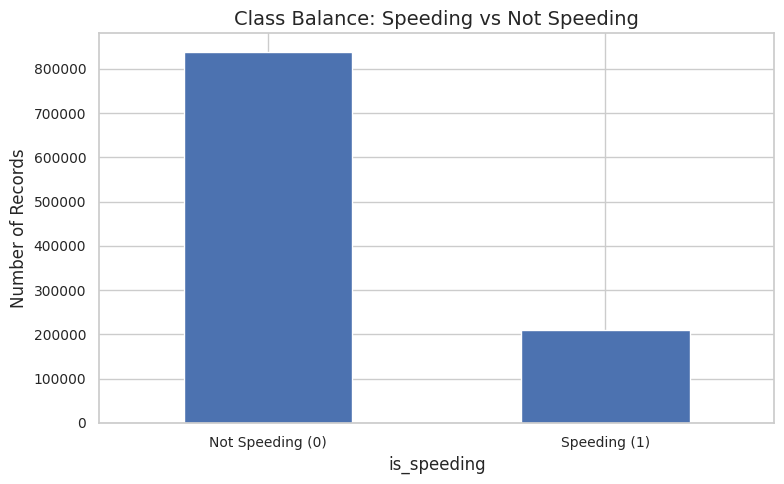

Speeding rate: 0.2007


In [9]:
# Presentation: class balance
import matplotlib.pyplot as plt

counts = viol["is_speeding"].value_counts().sort_index()
plt.figure()
counts.plot(kind="bar")
plt.xticks([0, 1], ["Not Speeding (0)", "Speeding (1)"], rotation=0)
plt.title("Class Balance: Speeding vs Not Speeding")
plt.ylabel("Number of Records")
plt.show()

print("Speeding rate:", round(viol["is_speeding"].mean(), 4))


In [10]:
#  Car Brands – brand + price–based tiers

# Define luxury brands explicitly
luxury_brands = {
    "BMW", "MERCEDES-BENZ", "AUDI", "LEXUS", "ACURA",
    "INFINITI", "JAGUAR", "PORSCHE", "LAND ROVER", "VOLVO",
    "GENESIS", "TESLA", "ALFA ROMEO", "CADILLAC", "LINCOLN",
    "MASERATI", "BENTLEY", "ROLLS-ROYCE", "ASTON MARTIN"
}

def price_tier(row):
    brand = row["Brand_clean"]
    avg_price = row["avg_price"]

    # If it's in our luxury brand list:
    #   Luxury if > 50k, Mid if 30–50k, Budget if <30k
    if brand in luxury_brands:
        if avg_price > 50000:
            return "Luxury"
        elif avg_price >= 30000:
            return "Mid"
        else:
            return "Budget"
    if avg_price < 30000:
        return "Budget"
    else:
        return "Mid"

# Apply row-wise
brand_price["price_tier"] = brand_price.apply(price_tier, axis=1)

brand_price["price_tier"].value_counts()


,count
price_tier,
Mid,34
Budget,15
Luxury,13


In [11]:
viol_enriched = viol.merge(
    brand_price[["Brand_clean", "avg_price", "median_price", "listings_count", "price_tier"]],
    left_on="Make_clean",
    right_on="Brand_clean",
    how="left"   # ALL violations for ML
)

print("Original rows (viol):", len(viol))
print("Rows after merge:    ", len(viol_enriched))
print("Missing price_tier %:", (viol_enriched["price_tier"].isna().mean() * 100).round(2))


Original rows (viol): 1048575
Rows after merge:     1048575
Missing price_tier %: 20.53


In [12]:
# Presentation: merge coverage
total = len(viol_enriched)
missing_tier = viol_enriched["price_tier"].isna().sum()

print("Total rows in viol_enriched:", total)
print("Rows missing price_tier:", missing_tier, f"({missing_tier/total:.2%})")

# Top unmatched makes (useful for report)
unmatched_top = (
    viol_enriched.loc[viol_enriched["price_tier"].isna(), "Make_clean"]
    .value_counts()
    .head(15)
)
unmatched_top


Total rows in viol_enriched: 1048575
Rows missing price_tier: 215234 (20.53%)


,count
Make_clean,
HOND,36335
NISS,21620
MERZ,15522
MERCEDES-BENZ,10566
VOLK,8675
ACUR,8050
DODG,6667
CHRY,5970
MITS,5868


## 5. EDA: How do speeding violations distribute across price tiers and brands?

We analyze:

- How many violations are associated with each price tier?
- Which brands appear most in speeding violations?
- Compare tier distribution in *market* vs *violations*.


In [13]:
# Count violations per price tier
viol_tier_counts = viol_enriched["price_tier"].value_counts().sort_index()
viol_tier_counts


,count
price_tier,
Budget,28299
Luxury,72739
Mid,732303


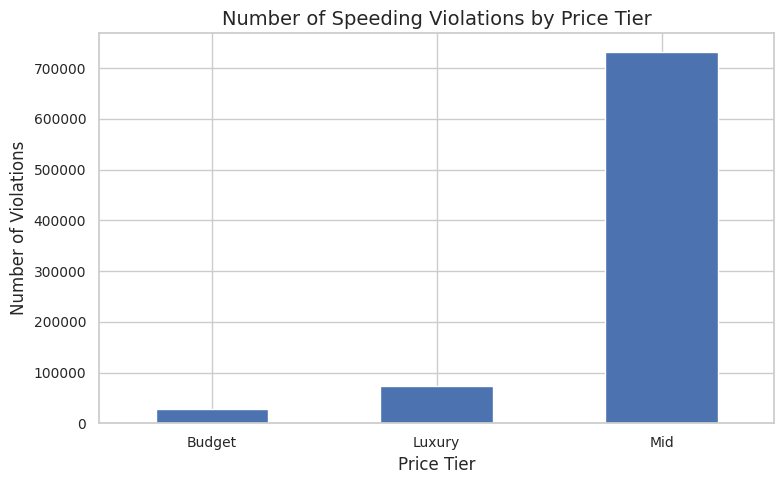

In [14]:
plt.figure()
viol_tier_counts.plot(kind="bar")
plt.title("Number of Speeding Violations by Price Tier")
plt.xlabel("Price Tier")
plt.ylabel("Number of Violations")
plt.xticks(rotation=0)
plt.show()


,count
Make_clean,
TOYOTA,168409
HONDA,117121
FORD,101582
CHEVROLET,80317
NISSAN,57043
HOND,36335
HYUNDAI,33945
BMW,31132
DODGE,29573


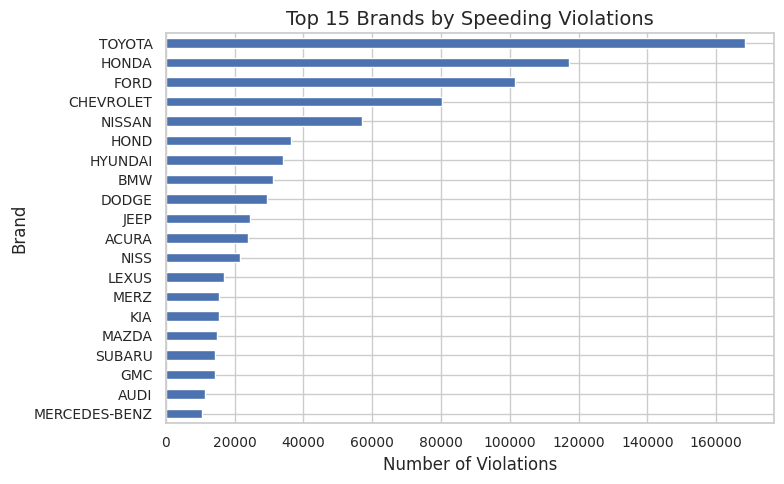

In [15]:
# Top brands by violation count
brand_counts = viol_enriched["Make_clean"].value_counts().head(20)
display(brand_counts)

plt.figure()
brand_counts.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 15 Brands by Speeding Violations")
plt.xlabel("Number of Violations")
plt.ylabel("Brand")
plt.show()


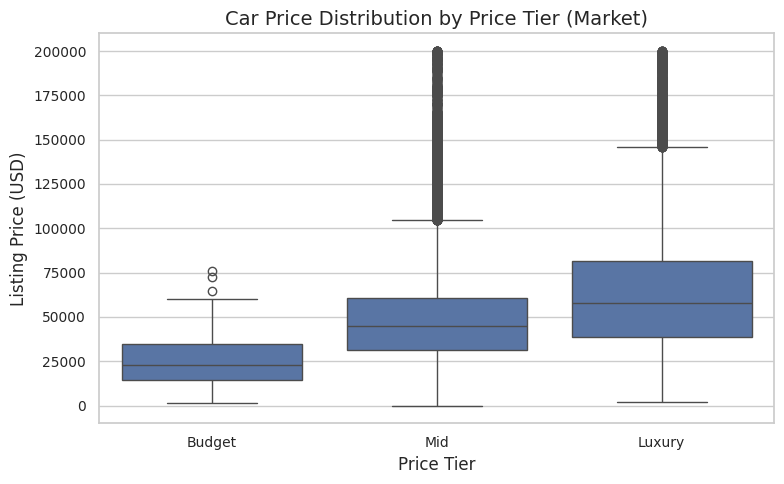

In [16]:
# Attach tier to each car listing using brand -> tier mapping
brand_to_tier = dict(zip(brand_price["Brand_clean"], brand_price["price_tier"]))
cars["price_tier"] = cars["Brand_clean"].map(brand_to_tier)

# Remove extreme prices for cleaner visualization (presentation choice)
cars_trimmed = cars[cars["Price"] < 200000]

plt.figure()
sns.boxplot(data=cars_trimmed,
            x="price_tier",
            y="Price",
            order=["Budget", "Mid", "Luxury"])
plt.title("Car Price Distribution by Price Tier (Market)")
plt.xlabel("Price Tier")
plt.ylabel("Listing Price (USD)")
plt.show()


Market tier counts:
 price_tier
Budget      1394
Luxury     28497
Mid       111065
Name: count, dtype: int64

Violation tier counts:
 price_tier
Budget     28299
Luxury     72739
Mid       732303
Name: count, dtype: int64


,Budget,Luxury,Mid
Market,1394,28497,111065
Violations,28299,72739,732303


<Figure size 800x500 with 0 Axes>

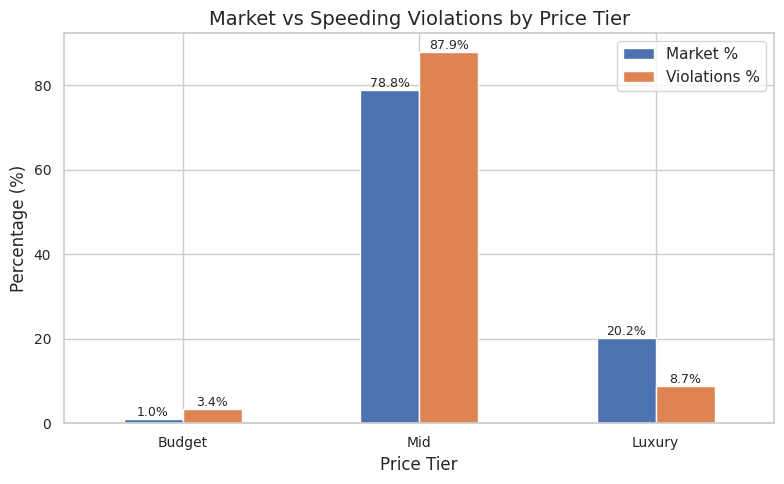

In [17]:
# Tier distribution in the market (cars dataset)
market_tier_counts = cars["price_tier"].value_counts().sort_index()

# Tier distribution among speeding violations (violations_enriched)
viol_tier_counts = viol_enriched["price_tier"].value_counts().reindex(
    market_tier_counts.index, fill_value=0
)

print("Market tier counts:\n", market_tier_counts)
print("\nViolation tier counts:\n", viol_tier_counts)

tiers = market_tier_counts.index.tolist()

# 2x3 contingency table for chi-square
observed = np.vstack([
    market_tier_counts.values,
    viol_tier_counts.values
])

obs_df = pd.DataFrame(observed, index=["Market", "Violations"], columns=tiers)
display(obs_df)

# Also plot normalized percentages for presentation
market_pct = (market_tier_counts / market_tier_counts.sum()) * 100
viol_pct = (viol_tier_counts / viol_tier_counts.sum()) * 100

df_compare = pd.DataFrame({
    "Market %": market_pct,
    "Violations %": viol_pct
}).reindex(["Budget", "Mid", "Luxury"])

plt.figure()
ax = df_compare.plot(kind="bar")
plt.title("Market vs Speeding Violations by Price Tier")
plt.ylabel("Percentage (%)")
plt.xlabel("Price Tier")
plt.xticks(rotation=0)

# Add percentage labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}%",
                    (bar.get_x() + bar.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.show()


In [18]:
chi2, p_value, dof, expected = chi2_contingency(observed)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p_value)

expected_df = pd.DataFrame(expected, index=["Market", "Violations"], columns=tiers)
print("\nExpected counts if there is NO relationship:")
display(expected_df)


Chi-square statistic: 18754.339239401954
Degrees of freedom: 2
p-value: 0.0

Expected counts if there is NO relationship:


,Budget,Luxury,Mid
Market,"4,295.82","14,646.27","122,013.90"
Violations,"25,397.18","86,589.73","721,354.10"


## Normalization Step

Different price tiers have very different levels of presence in the U.S. car market.  
For example, mid-priced brands (Toyota, Honda, Nissan, Hyundai) are far more common
than luxury brands.

If we compared raw speeding counts without considering brand frequency, the results
would be misleading.

### Why Normalize?

Normalization adjusts speeding counts by the number of vehicles available in the market.

To do this, we use the Kaggle sales dataset as an approximate representation of the
market distribution of car brands.

- **Market Tier Distribution** = Percentage of vehicles in each price tier  
- **Violation Tier Distribution** = Percentage of speeding tickets in each price tier  

Then we compare:

> **Normalized speeding percentage vs. market percentage**

This ensures that results reflect true behavioral differences, not differences in
how common each brand is.

### Example from this analysis

- Mid-tier cars are **78.8%** of the market but **87.9%** of violations  
- Luxury cars are **20.2%** of the market but **8.7%** of violations  
- Budget-tier cars are **1.0%** of the market but **3.4%** of violations



This confirms that normalization is essential for correct interpretation.


### Interpretation of Hypothesis Test (Chi-square)

- **H₀ (null):** Price tier and speeding violations are independent (tier distribution in violations matches the market distribution).
- **H₁ (alternative):** The tier distribution in speeding violations differs from the market distribution.

The chi-square statistic and p-value are printed in the output above.  
If the **p-value < 0.05**, we reject H₀ and conclude that some tiers are over- or under-represented in speeding violations relative to their market presence.


## Results Summary

After cleaning, merging, and analyzing both datasets, we compared the **distribution of car price tiers in the overall market** (based on the cars dataset) versus the **distribution of price tiers involved in speeding violations**.

### Chi-square test

- **Chi-square statistic:** ~18754.33
- **Degrees of freedom:** 2  
- **p-value:** < 0.000001 (printed as 0.0)  

This is an *extremely* significant result.

### What does this mean?

We reject the null hypothesis:

> H₀: Price tier and speeding violations are independent.

Instead, the distributions are **very different**, showing that **certain price tiers are more involved in speeding violations than expected**.

---

## What data actually shows

| Tier       | Market %  | Violations % |
| ---------- | --------- | ------------ |
| **Budget** | **1.0%**  | **3.4%**     |
| **Mid**    | **78.8%** | **87.9%**    |
| **Luxury** | **20.2%** | **8.7%**     |


### Mid-tier cars (e.g., Toyota, Honda, Nissan, Hyundai, Ford)
- **Over-represented** in speeding violations  
- Appear *much more often* in violations than in the market  

### Luxury cars (e.g., BMW, Mercedes, Audi)
- **Under-represented** in violations  
- They are common in the market but appear far less in violations  

### Budget-tier cars
- Appear low overall  
- But still **double** their expected percentage

---

## Key Interpretation

The findings **do not** support the stereotype that “expensive cars speed more.”

Instead, the data strongly suggests:

### **-Mid-priced cars speed more frequently relative to their market share.**  
### **-Luxury cars speed less than expected based on market presence.**  

This is a valuable and interesting insight because it contradicts common assumptions.


### Top Brands by Speeding Violations Within Each Tier

To further dissect the findings, let's examine which specific brands are most frequently involved in speeding violations within the 'Mid' and 'Luxury' price tiers. This helps to identify the individual contributors to the overall tier-level trends.


Top 10 Brands in Mid-Tier by Speeding Violations:


,count
Make_clean,
TOYOTA,168409
HONDA,117121
FORD,101582
CHEVROLET,80317
NISSAN,57043
HYUNDAI,33945
DODGE,29573
JEEP,24572
ACURA,24013



Top 10 Brands in Luxury-Tier by Speeding Violations:


,count
Make_clean,
BMW,31132
LEXUS,17021
AUDI,11291
CADILLAC,4559
LINCOLN,4049
PORSCHE,1667
JAGUAR,1403
LAND ROVER,1301
MASERATI,214


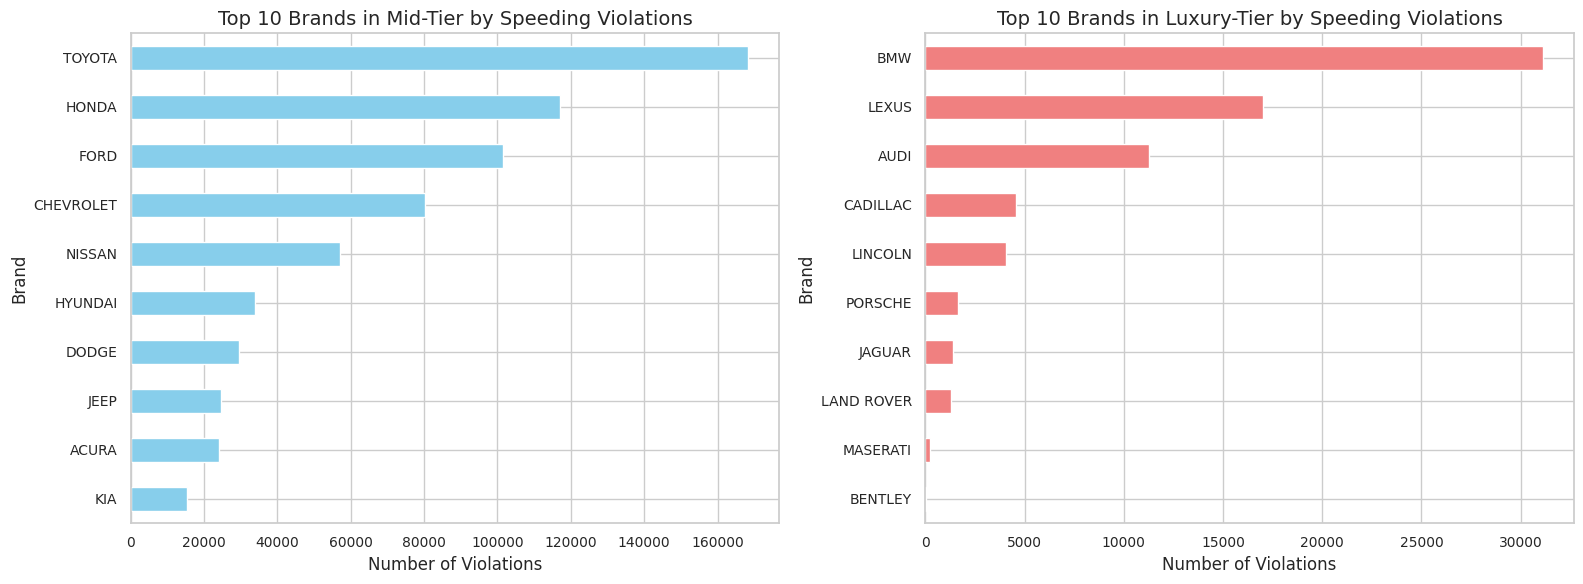

In [19]:
# Top brands in Mid tier by violation count
mid_tier_brands = viol_enriched[viol_enriched['price_tier'] == 'Mid']['Make_clean'].value_counts().head(10)
print("\nTop 10 Brands in Mid-Tier by Speeding Violations:")
display(mid_tier_brands)

# Top brands in Luxury tier by violation count
luxury_tier_brands = viol_enriched[viol_enriched['price_tier'] == 'Luxury']['Make_clean'].value_counts().head(10)
print("\nTop 10 Brands in Luxury-Tier by Speeding Violations:")
display(luxury_tier_brands)

# Plotting top brands per tier
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

mid_tier_brands.sort_values(ascending=True).plot(kind="barh", ax=axes[0], color='skyblue')
axes[0].set_title("Top 10 Brands in Mid-Tier by Speeding Violations")
axes[0].set_xlabel("Number of Violations")
axes[0].set_ylabel("Brand")

luxury_tier_brands.sort_values(ascending=True).plot(kind="barh", ax=axes[1], color='lightcoral')
axes[1].set_title("Top 10 Brands in Luxury-Tier by Speeding Violations")
axes[1].set_xlabel("Number of Violations")
axes[1].set_ylabel("Brand")

plt.tight_layout()
plt.show()

## 6. Machine Learning (Predict `is_speeding`)

We train classification models to predict whether a traffic-violation record is a **speeding** violation (`is_speeding` = 1) or not (`is_speeding` = 0), using:

- **Vehicle info:** Make, model, vehicle year, price tier, and brand-level price statistics  
- **Context:** Stop time (hour) and approximate location bins (lat/lon rounded)

Note: We intentionally avoid using the raw `Violation` text as a feature to prevent label leakage.


In [20]:
import numpy as np
import pandas as pd

viol_enriched["dow"] = np.nan
viol_enriched["month"] = np.nan

# -Time feature: parse "Time Of Stop" as HHMM (e.g., 1345, 0830, 945)
s = viol_enriched["Time Of Stop"].astype(str).str.strip()

hhmm = s.str.extract(r"^\s*(\d{1,2})(\d{2})\s*$")  # hour, minute
hour_num = pd.to_numeric(hhmm[0], errors="coerce")
min_num  = pd.to_numeric(hhmm[1], errors="coerce")

valid = hour_num.between(0, 23) & min_num.between(0, 59)
viol_enriched["hour"] = np.where(valid, hour_num, np.nan)

# -Location bins
viol_enriched["lat_bin"] = pd.to_numeric(viol_enriched["Latitude"], errors="coerce").round(2)
viol_enriched["lon_bin"] = pd.to_numeric(viol_enriched["Longitude"], errors="coerce").round(2)

# -Vehicle year
viol_enriched["veh_year"] = pd.to_numeric(viol_enriched["Year"], errors="coerce")

# -Fill missing tier for ML
viol_enriched["price_tier"] = viol_enriched["price_tier"].fillna("Unknown")


In [21]:
from sklearn.model_selection import train_test_split

target = "is_speeding"

feature_cols = [
    "Make_clean", "Model", "price_tier",
    "avg_price", "median_price",
    "hour",
    "lat_bin", "lon_bin",
    "veh_year"
]

df_ml = viol_enriched[feature_cols + [target]].copy()

X = df_ml[feature_cols]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train speeding rate:", y_train.mean())
print("Test speeding rate: ", y_test.mean())


Train speeding rate: 0.20069379872684356
Test speeding rate:  0.2006914145387788


In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

cat_cols = ["Make_clean", "Model", "price_tier", "lat_bin", "lon_bin"]
num_cols = ["avg_price", "median_price", "hour", "veh_year"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
    ]
)

log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))

])

log_reg.fit(X_train, y_train)

proba = log_reg.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))
print(classification_report(y_test, pred, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hour']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hour']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


ROC-AUC: 0.6976088795132642
PR-AUC : 0.37759911979008126
              precision    recall  f1-score   support

           0      0.876     0.666     0.757    167627
           1      0.320     0.626     0.423     42088

    accuracy                          0.658    209715
   macro avg      0.598     0.646     0.590    209715
weighted avg      0.765     0.658     0.690    209715



<Figure size 800x500 with 0 Axes>

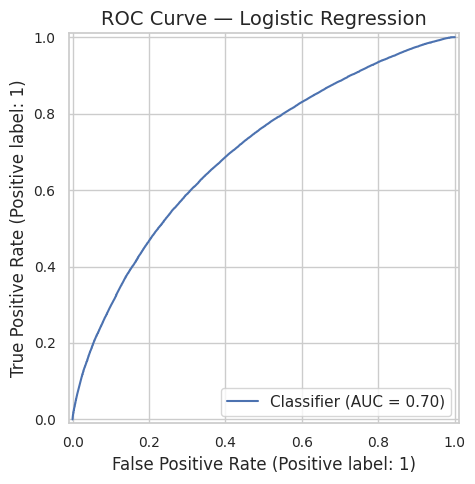

<Figure size 800x500 with 0 Axes>

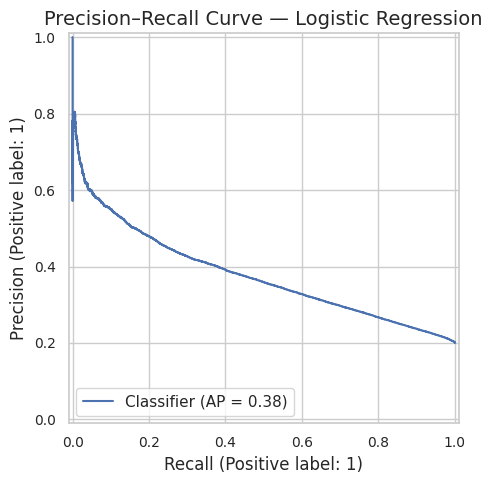

In [25]:
# Presentation: ROC & Precision–Recall curves (Logistic Regression)
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Safety checks (helps if cells are run out of order)
if "y_test" not in globals():
    raise NameError("y_test is not defined. Run the Train/Test Split cell first.")
if "proba" not in globals():
    raise NameError("proba is not defined. Run the Logistic Regression cell first.")

plt.figure()
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve — Logistic Regression")
plt.show()

plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision–Recall Curve — Logistic Regression")
plt.show()


Best threshold: 0.49999999999999994
Precision=0.320, Recall=0.626, F1=0.423


<Figure size 800x500 with 0 Axes>

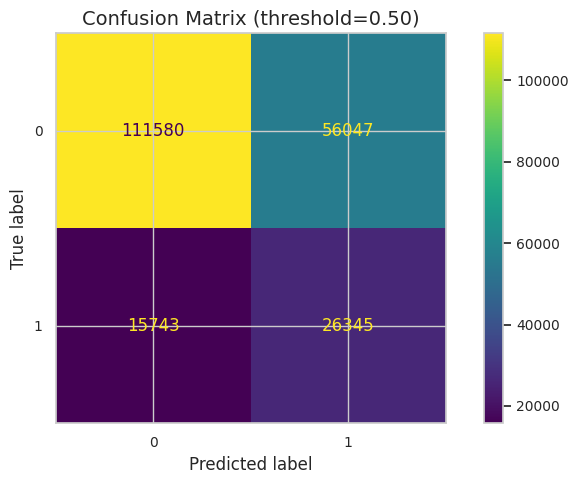

In [26]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Safety checks
if "y_test" not in globals():
    raise NameError("y_test is not defined. Run the Train/Test Split cell first.")
if "proba" not in globals():
    raise NameError("proba is not defined. Run the Logistic Regression cell first.")

# Try multiple thresholds and pick the best F1
thresholds = np.linspace(0.05, 0.95, 19)

best = {"thr": None, "f1": -1, "precision": None, "recall": None}
for t in thresholds:
    pred_t = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, pred_t, average="binary", zero_division=0
    )
    if f1 > best["f1"]:
        best = {"thr": t, "f1": f1, "precision": p, "recall": r}

print("Best threshold:", best["thr"])
print(f"Precision={best['precision']:.3f}, Recall={best['recall']:.3f}, F1={best['f1']:.3f}")

plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, (proba >= best["thr"]).astype(int))
plt.title(f"Confusion Matrix (threshold={best['thr']:.2f})")
plt.show()


In [27]:
# Presentation: threshold summary table
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

rows = []
for t in [0.30, 0.40, 0.50, float(best["thr"])]:
    pred_t = (proba >= t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred_t, average="binary", zero_division=0)
    rows.append({"threshold": round(t, 2), "precision": p, "recall": r, "f1": f1})

pd.DataFrame(rows).sort_values("threshold")


,threshold,precision,recall,f1
0,0.30,0.23,0.93,0.37
1,0.40,0.27,0.79,0.40
2,0.50,0.32,0.63,0.42
3,0.50,0.32,0.63,0.42


In [29]:
# Interpretability: top positive/negative Logistic Regression coefficients (robust)
import numpy as np
import pandas as pd

prep = log_reg.named_steps["prep"]
model = log_reg.named_steps["model"]

# Get the actual feature names produced by the fitted preprocessor
feature_names = prep.get_feature_names_out()
coefs = model.coef_.ravel()

print("Number of feature names:", len(feature_names))
print("Number of coefficients:", len(coefs))

# Safety: trim if anything is off (should usually match)
n = min(len(feature_names), len(coefs))
feature_names = feature_names[:n]
coefs = coefs[:n]

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

top_pos = coef_df.head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)

print("Top features increasing predicted speeding probability:")
display(top_pos)

print("\nTop features decreasing predicted speeding probability:")
display(top_neg)


Number of feature names: 18451
Number of coefficients: 18451
Top features increasing predicted speeding probability:


,feature,coef
10259,cat__Model_GD CARAVAN,2.94
18380,cat__lon_bin_38.94,2.87
17217,cat__Model_TWO DOOR,2.81
11460,cat__Model_JOURNEY SUV,2.65
13896,cat__Model_RDX SUV,2.52
2187,cat__Make_clean_PORSCH,2.51
4313,cat__Model_42,2.51
4942,cat__Model_4S 3,2.49
156,cat__Make_clean_AUD,2.41
1718,cat__Make_clean_MERCEDEES,2.30



Top features decreasing predicted speeding probability:


,feature,coef
16920,cat__Model_TRAILER,-4.74
14804,cat__Model_SEPHIA,-3.41
2543,cat__Make_clean_TAO TAO,-3.25
2534,cat__Make_clean_TAIZHOU,-3.15
15403,cat__Model_STAKE BODY,-3.08
18443,cat__lon_bin_39.7,-2.92
5746,cat__Model_740IL,-2.77
4173,cat__Model_3500HD,-2.72
6906,cat__Model_CAM 4D,-2.68
9419,cat__Model_EXPLORE,-2.66


## Conclusion & Limitations

**Conclusion**
- The **tier distribution** in speeding violations differs from the market distribution (see Market vs Violations + chi-square section).
- A baseline **Logistic Regression** model achieves **moderate predictive performance** (ROC-AUC and PR-AUC reported above).
- The most influential signals typically come from **brand/tier patterns**, **hour of day**, and **location bins** (see coefficients).

**Limitations**
- This is one county’s data (generalization to all U.S. driving is limited).
- “Market presence” is approximated using Kaggle listings (imperfect proxy).
- Enforcement and reporting biases may affect observed violations.
- Predictive models here show **association**, not causation.
